In [1]:
import math
import probros as pr
import numpy as np

In [2]:
np.random.seed(0)

We use the `@pr.probabilistic_prgram` decorator to construct a probabilistic program from a python function.

## BRP model

In [3]:
@pr.probabilistic_program
def brp(toSend, maxFailed):
    sent = 0
    failed = 0
    totalFailed = 0

    i = 1
    while failed < maxFailed and sent < toSend:
        b = pr.sample(f"attempt_transmit_{i}", pr.Bernoulli(0.1))
        if b:
            failed = 0
            sent = sent + 1
        else:
            failed = failed + 1
            totalFailed = totalFailed + 1
        i += 1

    return totalFailed

In [4]:
brp(5, 3) # trace has variable number of random value draws

(3,
 -0.3160815469734789,
 Trace(input=((5, 3), {}))
 0.: {'address': 'attempt_transmit_1', 'kind': 'sample', 'value': 0, 'logprob': -0.10536051565782631, 'distribution': Bernoulli(p=0.1)}
 1.: {'address': 'attempt_transmit_2', 'kind': 'sample', 'value': 0, 'logprob': -0.10536051565782631, 'distribution': Bernoulli(p=0.1)}
 2.: {'address': 'attempt_transmit_3', 'kind': 'sample', 'value': 0, 'logprob': -0.10536051565782631, 'distribution': Bernoulli(p=0.1)}
 retval=3
 logprob: -0.3160815469734789)

In [5]:
@pr.probabilistic_program
def brp(toSend, maxFailed):
    sent = 0
    failed = 0
    totalFailed = 0

    while failed < maxFailed and sent < toSend:
        b = pr.sample(f"attempt_transmit", pr.Bernoulli(0.1))
        if b:
            failed = 0
            sent = sent + 1
        else:
            failed = failed + 1
            totalFailed = totalFailed + 1

    return totalFailed

In [6]:
brp(5, 3) # now addresses need not be unique

(3,
 -0.3160815469734789,
 Trace(input=((5, 3), {}))
 0.: {'address': 'attempt_transmit', 'kind': 'sample', 'value': 0, 'logprob': -0.10536051565782631, 'distribution': Bernoulli(p=0.1)}
 1.: {'address': 'attempt_transmit', 'kind': 'sample', 'value': 0, 'logprob': -0.10536051565782631, 'distribution': Bernoulli(p=0.1)}
 2.: {'address': 'attempt_transmit', 'kind': 'sample', 'value': 0, 'logprob': -0.10536051565782631, 'distribution': Bernoulli(p=0.1)}
 retval=3
 logprob: -0.3160815469734789)

## Coin flip model

We want to infer if a coin is biased.

What is the true probability of flipping the heads (== 1).

We have observed following flips 0,0,1,1,1.

In [7]:
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    for i in range(len(data)):
        pr.observe(data[i], f"flip_{i}", pr.Bernoulli(p))
    return p

In [8]:
data = [0,0,1,1,1]
coin_flips(data)

(0.4375872112626925,
 -3.6304761574003996,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.4375872112626925, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': 'flip_0', 'kind': 'observe', 'value': 0, 'logprob': -0.5755191991686398, 'distribution': Bernoulli(p=0.4375872112626925)}
 2.: {'address': 'flip_1', 'kind': 'observe', 'value': 0, 'logprob': -0.5755191991686398, 'distribution': Bernoulli(p=0.4375872112626925)}
 3.: {'address': 'flip_2', 'kind': 'observe', 'value': 1, 'logprob': -0.8264792530210401, 'distribution': Bernoulli(p=0.4375872112626925)}
 4.: {'address': 'flip_3', 'kind': 'observe', 'value': 1, 'logprob': -0.8264792530210401, 'distribution': Bernoulli(p=0.4375872112626925)}
 5.: {'address': 'flip_4', 'kind': 'observe', 'value': 1, 'logprob': -0.8264792530210401, 'distribution': Bernoulli(p=0.4375872112626925)}
 retval=0.4375872112626925
 logprob: -3.6304761574003996)

Running the model corresponds to:
- `sample` a value for `p`,
- add to log probability `logprob += logpdf(Uniform(0,1), p)`
- `observe` each data point `data[i]`
- add to the log probability `logprob += logpdf(Bernoulli(p), data[i])` (depends on `p`)
- return `p`, `logprob`, and trace


`logprob = logpdf(Uniform(0,1), p) + logpdf(Bernoulli(p), data[0]) + logpdf(Bernoulli(p), data[1]) + logpdf(Bernoulli(p), data[2]) + logpdf(Bernoulli(p), data[3]) + logpdf(Bernoulli(p), data[4])`

Thus,

`exp(logprob) = Prob(p,flip_0=0,flip_1=0,flip_2=1,flip_3=1,flip_4=1) = Prob(p, Y=data)`

The posterior is proportional to the joint:

`Prob(p|Y=data) = Prob(p, Y=data) / Prob(Y=data)`

In [9]:
# same model but explicitly vectorised
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    pr.observe(data, "flip", pr.IID(pr.Bernoulli(p), len(data)))
    return p
coin_flips(data)

(0.8917730007820798,
 -4.790679812715388,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.8917730007820798, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': 'flip', 'kind': 'observe', 'value': [0, 0, 1, 1, 1], 'logprob': -4.790679812715388, 'distribution': IID(Bernoulli(p=0.8917730007820798), 5)}
 retval=0.8917730007820798
 logprob: -4.790679812715388)

In [10]:
# same model but implicitly vectorised
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    pr.observe(data, "flip", pr.Bernoulli(p))
    return p
coin_flips(data)

(0.9636627605010293,
 -6.740866001355919,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.9636627605010293, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': 'flip', 'kind': 'observe', 'value': [0, 0, 1, 1, 1], 'logprob': -6.740866001355919, 'distribution': Bernoulli(p=0.9636627605010293)}
 retval=0.9636627605010293
 logprob: -6.740866001355919)

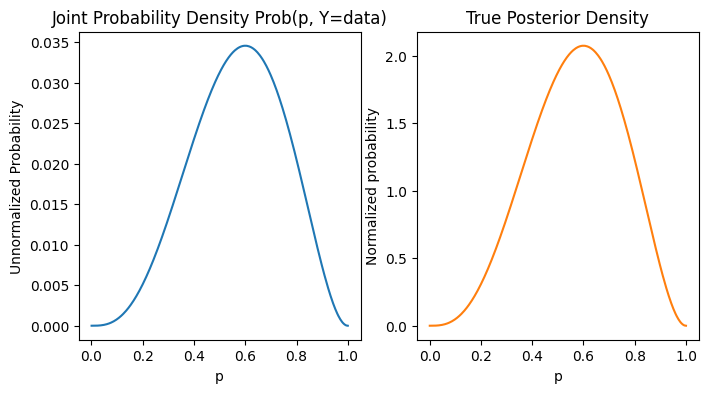

In [11]:
# We can make a few draws, and plot the result
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta 
samples = [coin_flips(data)[:2] for _ in range(1000)]
samples = sorted(samples)

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ps = np.array([s[0] for s in samples])
logprobs = np.array([s[1] for s in samples])
ax[0].plot(ps, np.exp(logprobs))
ax[0].set_xlabel("p")
ax[0].set_ylabel("Unnormalized Probability")
ax[0].set_title("Joint Probability Density Prob(p, Y=data)")
ax[1].plot(ps, beta.pdf(ps, 3+1,2+1), c="tab:orange")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Normalized probability")
ax[1].set_title("True Posterior Density")
plt.show()

In [12]:
# Indeed the area under the curve does not equal 1 -> unnormalized
np.trapz(np.exp(logprobs), ps)

0.01666662501016135

We can also equivalently formulate the model in terms of a factor.

Essentially, observe statements are factors: `factor(distribution.logprob(value)) ~ observe(value, distribution)`.

In [13]:
@pr.probabilistic_program
def coin_flips_factor(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    f = 0.
    for i in range(len(data)):
        f += math.log(p if data[i] == 1 else 1-p)
    pr.factor(f)
    return p

In [14]:
coin_flips_factor(data)

(0.953675696427313,
 -6.286471899401944,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.953675696427313, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': 'factor:1', 'kind': 'factor', 'logprob': -6.286471899401944}
 retval=0.953675696427313
 logprob: -6.286471899401944)

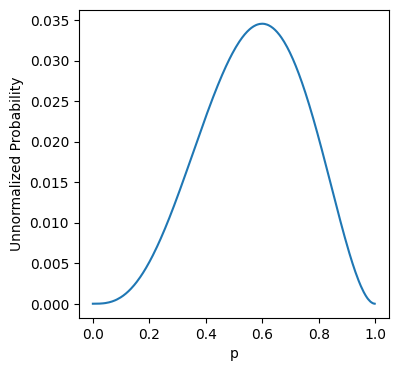

0.01666664670140041

In [15]:
samples = [coin_flips_factor(data)[:2] for _ in range(1000)]
samples = sorted(samples)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ps = np.array([s[0] for s in samples])
logprobs = np.array([s[1] for s in samples])
ax.plot(ps, np.exp(logprobs))
ax.set_xlabel("p")
ax.set_ylabel("Unnormalized Probability")
plt.show()
np.trapz(np.exp(logprobs), ps)

## Linear Regression Model

In more complicated models, where we have more than 1 latent variable, it is not as simple to compute the normalization constant as above.

Therefore, you need more sophisticated inference algorithms to approximate the posterior.

However, I think this is not the scope of our package.

Simply producing samples by running the model should be enough.

For instance, consider a linear regression model with 3 latents:

In [16]:
@pr.probabilistic_program
def linear_regression(x, y):
    slope = pr.sample("slope", pr.Normal(0, 10))
    intercept = pr.sample("intercept", pr.Normal(0, 10))
    sigma = pr.sample("sigma", pr.Uniform(0.1, 5))

    for i in range(len(x)):
        pr.observe(y[i], f"y_{i}", pr.Normal(slope * x[i] + intercept, sigma))

    return slope, intercept, sigma

In [17]:
x = [1,2,3,4,5]
y = [2.1, 3.9, 5.3, 7.7, 10.2]
(slope, intercept, sigma), logprob, _ = linear_regression(x,y)
(slope, intercept, sigma), logprob

((-16.193599828975426, -5.110404635801098, 0.744824566796781),
 -18966.97799539309)

## Discrete Model

Lastly, we consider a discrete model, with observe statements that assert that some program variables are true.

`pr.observe(called, "called") # == observe(called, "called", Dirac(True))`

This results in many traces having log-probability -inf.

In [18]:
@pr.probabilistic_program
def Burglary():
    earthquake = pr.sample("earthquake", pr.Bernoulli(0.0001))
    burglary = pr.sample("burglary", pr.Bernoulli(0.001))
    alarm = earthquake or burglary
    if earthquake:
        phoneWorking = pr.sample("phoneWorking", pr.Bernoulli(0.7))
    else:
        phoneWorking = pr.sample("phoneWorking", pr.Bernoulli(0.99))
    if alarm:
        if earthquake:
            maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.8))
        else:
            maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.6))
    else:
        maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.2))

    called = maryWakes and phoneWorking
    pr.observe(called, "called") # == observe(called, "called", Dirac(True))

    return burglary

In [19]:
Burglary()

(0,
 -inf,
 Trace(input=((), {}))
 0.: {'address': 'earthquake', 'kind': 'sample', 'value': 0, 'logprob': -0.00010000500033335834, 'distribution': Bernoulli(p=0.0001)}
 1.: {'address': 'burglary', 'kind': 'sample', 'value': 0, 'logprob': -0.0010005003335835335, 'distribution': Bernoulli(p=0.001)}
 2.: {'address': 'phoneWorking', 'kind': 'sample', 'value': 1, 'logprob': -0.01005033585350145, 'distribution': Bernoulli(p=0.99)}
 3.: {'address': 'maryWakes', 'kind': 'sample', 'value': 0, 'logprob': -0.22314355131420976, 'distribution': Bernoulli(p=0.2)}
 4.: {'address': 'called', 'kind': 'observe', 'value': 0, 'logprob': -inf, 'distribution': Dirac(value=True)}
 retval=0
 logprob: -inf)

We would have to run this model with rejection sampling.

Running this function leads to probability 0 traces in over 75% of cases.

Or you would need more powerful inference algorithms, but for our purposes - sanity checking - I think just producing samples is enough.

In [20]:
samples = [Burglary()[:2] for _ in range(1000)]
logprobs = np.array([s[1] for s in samples])
np.mean(np.exp(logprobs) == 0)

0.809

## Translating to other languages

I just had a quick idea to reuse the `Unparser` from the `ast` module.

But I have not put much thought into this.

Also Python 3.10 has `match` statements.

For this demo, I only translate the sample and observe statements to Turing syntax and leave all other Python syntax unchanged.

In [21]:
import ast

class TuringTranslator(ast._Unparser):
    def _write_arguments(self, args, keywords):
        with self.delimit("(", ")"):
            comma = False
            for e in args:
                if comma:
                    self.write(", ")
                else:
                    comma = True
                self.traverse(e)
            for e in keywords:
                if comma:
                    self.write(", ")
                else:
                    comma = True
                self.traverse(e)

    def visit_Assign(self, node):
        match node:
            case ast.Assign(
                targets=[prog_name],
                value=ast.Call(
                    func=ast.Attribute(value=ast.Name(id="pr"), attr="sample"),
                    args=[
                        address,
                        ast.Call(func=ast.Attribute(value=ast.Name(id="pr"), attr=distribution_name), args=args, keywords=keywords)
                    ]
                )
            ):
                self.fill()
                self.traverse(prog_name)
                self.write(" ~ ")
                self.write(distribution_name)
                self._write_arguments(args, keywords)

            case _:
                super().visit_Assign(node)

    def visit_Call(self, node):
        match node:
            case ast.Call(
                func=ast.Attribute(value=ast.Name(id="pr"), attr="observe"),
                    args=[
                        value,
                        address,
                        ast.Call(func=ast.Attribute(value=ast.Name(id="pr"), attr=distribution_name), args=args, keywords=keywords)
                    ]
            ):
                self.traverse(value)
                self.write(" ~ ")
                self.write(distribution_name)
                self._write_arguments(args, keywords)

            case _:
                super().visit_Call(node)

In [22]:
source_code = """
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    for i in range(len(data)):
        pr.observe(data[i], f"flip_{i}", pr.Bernoulli(p))
    return p
"""

In [23]:
source_tree = ast.parse(source_code)
result = TuringTranslator().visit(source_tree)
print(result)

@pr.probabilistic_program
def coin_flips(data):
    p ~ Uniform(0, 1)
    for i in range(len(data)):
        data[i] ~ Bernoulli(p)
    return p


### Translations:

```
def model(input, data):
    x = pr.sample("X", Distribution(...))
    pr.observe(data, "data", Distribution(...))
    return x
```

#### Turing
```
@model function model(input, data):
    x ~ Distribution(...)
    data ~ Distribution(...)
    return x
```

#### Gen
```
@gen function model(input, data):
    x = {"X"} ~ Distribution(...)
    {"data"} ~ Distribution(...)
    return x
choicemap("data" => data)
```

#### Pyro
```
def model(input, data):
    x = pyro.sample("X", Distribution(...))
    pyro.sample("data", Distribution(...), obs=data)
```

#### PyMC
```
input = ...
data = ....
with pm.Model() as model:
    x = pm.Distribution("X", ...)
    pm.Distribution("data", ..., observed=data)
```


In [24]:
@pr.probabilistic_program
def gmm(data):
    mu0 = pr.sample("mu0", pr.Normal(0,1))
    mu1 = pr.sample("mu1", pr.Normal(0,1))

    z = pr.Vector(len(data), int)
    for i in range(len(data)):
        z[i] = pr.sample(f"z_{i}", pr.Bernoulli(0.5))
        if z[i] == 0:
            mu = mu0
        else:
            mu = mu1

        pr.observe(data[i], "data_{i}", pr.Normal(mu, 1))

    return (mu0, mu1)

In [25]:
gmm([-1., 1.])

((0.8056691268403157, -0.3031520602462005),
 -7.91187359460025,
 Trace(input=(([-1.0, 1.0],), {}))
 0.: {'address': 'mu0', 'kind': 'sample', 'value': 0.8056691268403157, 'logprob': -1.2434899041764909, 'distribution': Normal(loc=0, scale=1)}
 1.: {'address': 'mu1', 'kind': 'sample', 'value': -0.3031520602462005, 'logprob': -0.9648891190204306, 'distribution': Normal(loc=0, scale=1)}
 2.: {'address': 'z_0', 'kind': 'sample', 'value': 0, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 3.: {'address': 'data_{i}', 'kind': 'observe', 'value': -1.0, 'logprob': -2.5491590310168064, 'distribution': Normal(loc=0.8056691268403157, scale=1)}
 4.: {'address': 'z_1', 'kind': 'sample', 'value': 1, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 5.: {'address': 'data_{i}', 'kind': 'observe', 'value': 1.0, 'logprob': -1.7680411792666313, 'distribution': Normal(loc=-0.3031520602462005, scale=1)}
 retval=(0.8056691268403157, -0.3031520602462005)
 logprob: -7.9118735

```

```

#### Turing
```
@model function model(data):
    mu0 ~ Normal(0,1)
    mu1 ~ Normal(0,1)
    
    z = Vector{Float64}(undef, length(data))
    for i in 1:length(data)
        z[i] ~ Bernoulli(0.5)

        if z[i] == 0
            mu = mu0
        else
            mu = mu1
        end
        
        data[i] ~ Normal(mu, 1)
    end

    return (mu0, mu1)
end
```

In [26]:
@pr.probabilistic_program
def urn(K, n_black_observed):
    N = int(pr.sample("N", pr.Poisson(6.)))
    balls = pr.Vector(N, int)
    for i in range(N):
        balls[i] = pr.sample(f"ball_{i}", pr.Bernoulli(0.5))

    n_black = 0
    for k in range(K):
        u = pr.sample(f"u_{k}", pr.Uniform(0, N))
        i = math.floor(u)
        n_black += balls[i]

    pr.observe(n_black_observed, "n_black", pr.Dirac(n_black))

    return N

In [27]:
urn(10, 5)

(5,
 -inf,
 Trace(input=((10, 5), {}))
 0.: {'address': 'N', 'kind': 'sample', 'value': 5, 'logprob': -1.8286943966417715, 'distribution': Poisson(mu=6.0)}
 1.: {'address': 'ball_0', 'kind': 'sample', 'value': 1, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 2.: {'address': 'ball_1', 'kind': 'sample', 'value': 1, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 3.: {'address': 'ball_2', 'kind': 'sample', 'value': 1, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 4.: {'address': 'ball_3', 'kind': 'sample', 'value': 0, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 5.: {'address': 'ball_4', 'kind': 'sample', 'value': 0, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 6.: {'address': 'u_0', 'kind': 'sample', 'value': 2.3906011596858887, 'logprob': -1.6094379124341003, 'distribution': Uniform(loc=0, scale=5)}
 7.: {'address': 'u_1', 'kind': 'sample', 'value': 1.2786676601579288, 'logprob': -1.

In [28]:
@pr.probabilistic_program
def hmm(data):
    z = pr.Vector(len(data), float)
    z[1] =  pr.sample(f"z[1]", pr.Bernoulli(0.5))
    p = pr.sample("p", pr.Uniform(0.,1.))
    for i in range(1, len(data)):
        if z[i-1] == 0:
            p_stay = 1-p
        else:
            p_stay = p

        z[i] = pr.sample(f"z[{i}]", pr.Bernoulli(p_stay))
        pr.observe(data[i], f"x[{i}]", pr.Normal(z[i], 1.))

In [29]:
hmm([1.,1.,1.])

(None,
 -2.653733503644219,
 Trace(input=(([1.0, 1.0, 1.0],), {}))
 0.: {'address': 'z[1]', 'kind': 'sample', 'value': 0, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 1.: {'address': 'p', 'kind': 'sample', 'value': 0.9404896563472046, 'logprob': 0.0, 'distribution': Uniform(loc=0.0, scale=1.0)}
 2.: {'address': 'z[1]', 'kind': 'sample', 'value': 1, 'logprob': -0.06135462833746425, 'distribution': Bernoulli(p=0.9404896563472046)}
 3.: {'address': 'x[1]', 'kind': 'observe', 'value': 1.0, 'logprob': -0.9189385332046727, 'distribution': Normal(loc=1, scale=1.0)}
 4.: {'address': 'z[2]', 'kind': 'sample', 'value': 1, 'logprob': -0.06135462833746425, 'distribution': Bernoulli(p=0.9404896563472046)}
 5.: {'address': 'x[2]', 'kind': 'observe', 'value': 1.0, 'logprob': -0.9189385332046727, 'distribution': Normal(loc=1, scale=1.0)}
 retval=None
 logprob: -2.653733503644219)